# Chinese Characters (HSK 1 level) Recognition
Hello everyone! In this notebook we will build CRNN for OCR task. Our goal is to train neural network to recognize chinese characters. Let`s start!

# 1) Import Libraries and Load Data

**Firstly, lets import all useful libraries. Secondly, load data.**

In [1]:
import os
import sys
import shutil
import random
import time

import tqdm
from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.container import Sequential
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchvision.models as models

# 2) Fast looking on dataset

**Lets create dataframe with some information about our dataset to explore it and use it to interpritate results of neural network**

In [3]:
# moving directories from ../input - path to /kaggle/working
# to move images in directory for Validation data
os.mkdir("Validation_Images")
!cp -r ../input/chinese-handwriting-recognition-hsk-1/chinese-handwriting /kaggle/working

In [4]:
columns = ["Character_ID", "Character", "Paths", "Directory", "File_Name"]
IDS = []
characters = []
paths = []
files_names = []
directories_names = []

id = -1

paths_dirs = ["CASIA-HWDB_Train", "CASIA-HWDB_Test"]
ROOT_PATH = "./chinese-handwriting/"
for path_dir in paths_dirs:
    PATH = f"{ROOT_PATH}{path_dir}/{path_dir[11:]}"
    
    for directory in tqdm_notebook(os.listdir(PATH)):
        id += 1
        for file in os.listdir(f"{PATH}/{directory}"):
            IDS.append(id)
            characters.append(directory)
            paths.append(f"{PATH}/{directory}/{file}")
            files_names.append(file)
            directories_names.append(path_dir[11:])

data = pd.DataFrame({columns[0] : IDS,
                     columns[1] : characters,
                     columns[2] : paths,
                     columns[3] : directories_names,
                     columns[4] : files_names})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [5]:
data

,Character_ID,Character,Paths,Directory,File_Name
0,0,北,./chinese-handwriting/CASIA-HWDB_Train/Train/北...,Train,59.png
1,0,北,./chinese-handwriting/CASIA-HWDB_Train/Train/北...,Train,248.png
2,0,北,./chinese-handwriting/CASIA-HWDB_Train/Train/北...,Train,54.png
3,0,北,./chinese-handwriting/CASIA-HWDB_Train/Train/北...,Train,101.png
4,0,北,./chinese-handwriting/CASIA-HWDB_Train/Train/北...,Train,73.png
...,...,...,...,...,...
131945,355,饭,./chinese-handwriting/CASIA-HWDB_Test/Test/饭/1...,Test,104.png
131946,355,饭,./chinese-handwriting/CASIA-HWDB_Test/Test/饭/6...,Test,62.png
131947,355,饭,./chinese-handwriting/CASIA-HWDB_Test/Test/饭/8...,Test,85.png
131948,355,饭,./chinese-handwriting/CASIA-HWDB_Test/Test/饭/3...,Test,3.png


**Small conclusion**

In [6]:
print(f"There are {data.shape[0]} images in whole dataset.")
print(f"{len(data[data['Directory'] == 'Train'])} images in Train directory and {len(data[data['Directory'] == 'Test'])} in Test part.")
print(f"{round(np.array(data['Character_ID']).max() / 2)} characters (classes).")

There are 131950 images in whole dataset.
106531 images in Train directory and 25419 in Test part.
178 characters (classes).


In [7]:
def count_of_each_character(directory):
    count_numbers = []
    classes = []

    j = 0
    PATH = f"./chinese-handwriting/CASIA-HWDB_{directory}/{directory}"
    for character in os.listdir(PATH):
        classes.append(character)
        for image in os.listdir(os.path.join(PATH, character)):
            j += 1

        count_numbers.append(j)
        j = 0

    fig = go.Figure(data = [go.Bar(x = classes, y = count_numbers, marker_color = "royalblue")])

    fig.update_layout(title = f"Distribution of count of Images in {directory} dataset", xaxis_title = "Characters", yaxis_title = "Count", legend_title = "Legend")
    fig.update_layout(barmode = "group", xaxis={'categoryorder' : 'total descending'}, xaxis_tickangle = 0)

    fig.show()

In [8]:
count_of_each_character("Train")

In [9]:
count_of_each_character("Test")

**From this graph we can see that there is normal distribution of number of images in both datasets (train and test)**

**Examples of images in dataset**

In [10]:
def show_example_image(dataset, part):
    n = random.randint(50, 80)
    char = random.choice(dataset["Character"])
    PATH2image = f"./chinese-handwriting/CASIA-HWDB_{part}/{part}/{char}/{n}.png"

    example_image = cv2.imread(PATH2image, cv2.IMREAD_COLOR)
    print(f"Character: {char}")
    plt.axis("off")
    plt.imshow(example_image)

Character: 六


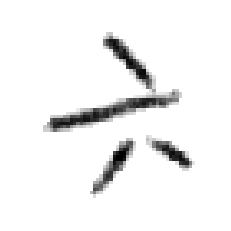

In [11]:
show_example_image(data, "Train")

# 3) Image&Dataset preparations

**Validation Images**

In [12]:
def move_validation_files(folder):
  os.mkdir(os.path.join("Validation_Images", str(folder)))
  
  destination_path = "Validation_Images/" + str(folder)
  folder_path_train = os.path.join("./chinese-handwriting/CASIA-HWDB_Train/Train", str(folder))

  files = os.listdir(folder_path_train)
  for i in range(75):
    file = files[i]  
    shutil.move(os.path.join(folder_path_train, file), destination_path)

folders = data["Character"].unique()

for folder in folders:
   move_validation_files(folder)

In [13]:
image_transformer = transforms.Compose([transforms.Resize(96),
                                        transforms.Grayscale(num_output_channels=1),
                                        transforms.ToTensor(),
                                        transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(25),
                                                                                   transforms.RandomAutocontrast(p = 0.5)]), p = 0.6),
                                        transforms.Normalize([0.5], [0.5])])

train_data = datasets.ImageFolder("./chinese-handwriting/CASIA-HWDB_Train/Train", transform = image_transformer)
test_data = datasets.ImageFolder("./chinese-handwriting/CASIA-HWDB_Test/Test", transform = image_transformer)
val_data = datasets.ImageFolder("./Validation_Images", transform = image_transformer)

In [14]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, shuffle=False)

In [15]:
print(f"Checking Train loader: {type(train_loader)}")
print(f"Checking Validation loader: {type(val_loader)}")
print(f"Checking Test loader: {type(test_loader)}")

Checking Train loader: <class 'torch.utils.data.dataloader.DataLoader'>
Checking Validation loader: <class 'torch.utils.data.dataloader.DataLoader'>
Checking Test loader: <class 'torch.utils.data.dataloader.DataLoader'>


**Examples of images in dataloaders**

In [16]:
nums = range(0, 178)
labels = sorted([dir for dir in os.listdir("../input/chinese-handwriting-recognition-hsk-1/chinese-handwriting/CASIA-HWDB_Train/Train")])

interpritation_dict = dict(zip(nums, labels))

interpritation_dict

{0: '一',
 1: '七',
 2: '三',
 3: '上',
 4: '下',
 5: '不',
 6: '东',
 7: '个',
 8: '中',
 9: '么',
 10: '九',
 11: '习',
 12: '书',
 13: '买',
 14: '了',
 15: '二',
 16: '五',
 17: '些',
 18: '京',
 19: '亮',
 20: '人',
 21: '什',
 22: '今',
 23: '他',
 24: '们',
 25: '会',
 26: '住',
 27: '作',
 28: '你',
 29: '候',
 30: '做',
 31: '儿',
 32: '先',
 33: '八',
 34: '六',
 35: '关',
 36: '兴',
 37: '再',
 38: '写',
 39: '冷',
 40: '几',
 41: '出',
 42: '分',
 43: '前',
 44: '北',
 45: '医',
 46: '十',
 47: '午',
 48: '去',
 49: '友',
 50: '叫',
 51: '吃',
 52: '同',
 53: '名',
 54: '后',
 55: '吗',
 56: '听',
 57: '呢',
 58: '和',
 59: '哪',
 60: '商',
 61: '喂',
 62: '喜',
 63: '喝',
 64: '四',
 65: '回',
 66: '国',
 67: '在',
 68: '坐',
 69: '块',
 70: '多',
 71: '大',
 72: '天',
 73: '太',
 74: '女',
 75: '她',
 76: '好',
 77: '妈',
 78: '姐',
 79: '子',
 80: '字',
 81: '学',
 82: '客',
 83: '家',
 84: '对',
 85: '小',
 86: '少',
 87: '岁',
 88: '工',
 89: '师',
 90: '年',
 91: '店',
 92: '开',
 93: '影',
 94: '很',
 95: '怎',
 96: '想',
 97: '我',
 98: '打',
 99: '日',
 100: '时',

torch.Size([16, 1, 96, 96])
0) 先
1) 今
2) 店
3) 喜
4) 谁
5) 下
6) 前
7) 冷
8) 能
9) 朋


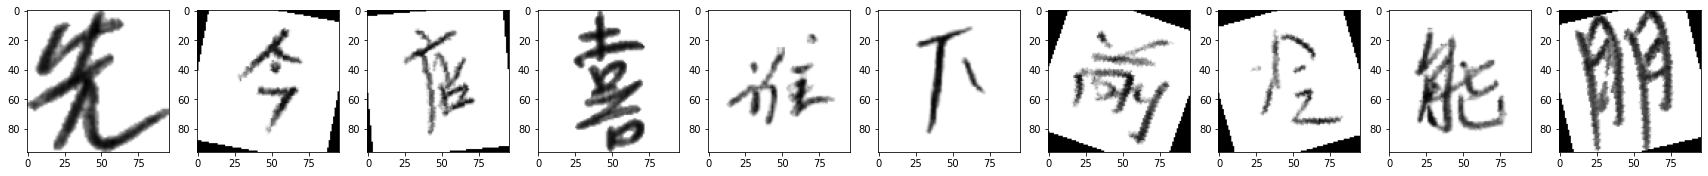

In [17]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)

def loaders_viz(imgs, labels):
  f, axes = plt.subplots(1, 10, figsize=(30,5))
  for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i][0].numpy(), (0, 1))), cmap = "gray")
      print(f"{i}) {interpritation_dict[int(labels[i].numpy())]}")

  plt.show()

loaders_viz(images, labels)

# 4) Model building and Training

**We will use CRNN architecture to solve our task because this type of neural networks is one of the best decisions in OCR.**

In [18]:
def CNN_backbone():
    relu = nn.ReLU()
    
    conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size=(7,7)) #90
    conv2 = nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = (7, 7)) #84
    conv3 = nn.Conv2d(in_channels = 96, out_channels = 128, kernel_size = (5, 5)) #80
    conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (5, 5)) #76
    conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3)) #74
    conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3)) #72
    pool = nn.MaxPool2d(kernel_size = (2,2)) #36
    conv7 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3)) #34
    bn1 = nn.BatchNorm2d(256)
    conv8 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3)) #32
    
    blocks = [conv1, relu, conv2, relu, conv3, relu, conv4, relu, 
              conv5, relu, conv6, pool, relu, conv7, bn1, relu, conv8, relu]
              
    return nn.Sequential(*blocks)

class CRNN(nn.Module):
    def __init__(self, number_class_symbols):
        super().__init__()
        self.feature_extractor = CNN_backbone()
        self.avg_pool1 = nn.AdaptiveAvgPool2d((100, 100))
        self.bilstm = nn.LSTM(input_size = 100, hidden_size = 100, num_layers = 1, 
                              batch_first = True, bidirectional = True)
        self.avg_pool2 = nn.AdaptiveAvgPool2d((64, 64))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64, 32)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, number_class_symbols)

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        
        x = self.avg_pool1(x)
        x = x.transpose(1, 2)
        x, _ = self.bilstm(x)
        
        x = self.avg_pool2(x)
        
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        self.gelu
        self.dropout
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CRNN(number_class_symbols = len(data["Character"].unique()))
model.to(device)
model

CRNN(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 96, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (17): ReLU()
  )
  (avg_pool1): AdaptiveAvgPool2d(output_size=(100, 100))
  (bilstm): LSTM(100, 100, batch_first=True, bidirectional=True)
  (avg_pool2): AdaptiveAvgPool2

**Training**

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00125, weight_decay = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):

    print('train() called: Model = %s, Optimizer = %s(lr=%f), Epochs = %d, Device = %s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    best_train_acc = 0
    best_val_acc = 0

    start_time_sec = time.time()

    for epoch in tqdm_notebook(range(1, epochs+1)):
        model.train()
        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0
        
        epoch_start_time_sec = time.time()

        for batch in train_dl:
            optimizer.zero_grad()
            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss += loss.data.item() * x.size(0)
            num_train_correct += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc = num_train_correct / num_train_examples
        train_loss = train_loss / len(train_dl.dataset)

        model.eval()
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0

        for batch in val_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss += loss.data.item() * x.size(0)
            num_val_correct += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)
        
        epoch_end_time_sec = time.time()
        epoch_time_sec = epoch_end_time_sec - epoch_start_time_sec

        print(f"Epoch {epoch}, time: {round(epoch_time_sec)} seconds. Train loss: {round(train_loss, 3)}, train accuracy: {round(train_acc, 3)}. Val loss: {round(val_loss, 3)}, val accuracy: {round(val_acc, 3)}")
        
        if train_acc > best_train_acc and val_acc > best_val_acc:
          best_train_acc = train_acc
          best_val_acc = val_acc

          best_epoch = epoch

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    end_time_sec = time.time()
    total_time_sec = end_time_sec - start_time_sec
    print("\n")
    print(f"Training Time: {round(total_time_sec)}")
    print(f"The best epoch: {best_epoch}, Train Accuracy: {round(best_train_acc, 3)}, Validation Accuracy: {round(best_val_acc, 3)}")

    return history

In [21]:
!nvidia-smi

Sun Apr 24 18:33:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |    799MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
history = train(model = model, optimizer = optimizer, loss_fn = loss_fn, epochs = 15, 
                train_dl = train_loader, val_dl = val_loader, device = device)

train() called: Model = CRNN, Optimizer = AdamW(lr=0.001250), Epochs = 15, Device = cuda



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1, time: 714 seconds. Train loss: 3.742, train accuracy: 0.169. Val loss: 2.868, val accuracy: 0.317
Epoch 2, time: 705 seconds. Train loss: 2.26, train accuracy: 0.458. Val loss: 2.981, val accuracy: 0.26
Epoch 3, time: 703 seconds. Train loss: 1.487, train accuracy: 0.637. Val loss: 1.466, val accuracy: 0.624
Epoch 4, time: 702 seconds. Train loss: 1.07, train accuracy: 0.736. Val loss: 0.947, val accuracy: 0.761
Epoch 5, time: 703 seconds. Train loss: 0.851, train accuracy: 0.785. Val loss: 0.902, val accuracy: 0.764
Epoch 6, time: 704 seconds. Train loss: 0.718, train accuracy: 0.817. Val loss: 0.788, val accuracy: 0.799
Epoch 7, time: 704 seconds. Train loss: 0.623, train accuracy: 0.84. Val loss: 0.684, val accuracy: 0.817
Epoch 8, time: 703 seconds. Train loss: 0.562, train accuracy: 0.854. Val loss: 0.568, val accuracy: 0.85
Epoch 9, time: 707 seconds. Train loss: 0.507, train accuracy: 0.869. Val loss: 0.549, val accuracy: 0.855
Epoch 10, time: 709 seconds. Train loss: 0

**Train summary**

In [23]:
from plotly.subplots import make_subplots

def train_summary(model_name, history, epochs):
    
    fig = make_subplots(rows = 1, cols = 2, subplot_titles = ("Train/Val accuracy", "Train/Val loss"))
    
    fig.add_trace(go.Scatter(x = epochs, y = history["acc"],
                             mode = "lines+markers",
                             name = "Train Accuracy"),
                             row = 1, col = 1)
    
    fig.add_trace(go.Scatter(x = epochs, y = history["val_acc"],
                             mode = "lines+markers",
                             name = "Validation Accuracy"),
                             row = 1, col = 1)

    fig.add_trace(go.Scatter(x = epochs, y = history["loss"],
                             mode = "lines+markers",
                             name = "Train Loss"),
                             row = 1, col = 2)
    
    fig.add_trace(go.Scatter(x = epochs, y = history["val_loss"],
                             mode = "lines+markers",
                             name = "Validation Loss"),
                             row = 1, col = 2)    
    
    fig.update_layout(height = 700, width = 1200, title_text = "Model training Summary", legend_title = "Legend")
    fig.update_xaxes(title_text = "Epochs")
    fig.update_yaxes(title_text = "Accuracy", row = 1, col = 1)
    fig.update_yaxes(title_text = "Loss", row = 1, col = 2)

    fig.show()

In [24]:
train_summary("CRNN", history, list(range(1, 15 + 1)))

# 5) Model testing and Conclusion

In [25]:
folders = data["Character"].unique()

def testing_model(model, image_transformer, folders, interpritation_dict):
    
    TEST_DIRECTORY_PATH = "./chinese-handwriting/CASIA-HWDB_Test/Test"
    
    random_folders = random.choices(folders, k = 10)
    
    for folder in random_folders:
        for image_name in os.listdir(os.path.join(TEST_DIRECTORY_PATH, folder)):
            image = Image.open(os.path.join(TEST_DIRECTORY_PATH, folder) + "/" + image_name)
            image_transformed = image_transformer(image).to(device)
            
            model_output = model(image_transformed.reshape((1, 1, 96, image_transformed.shape[2])))
            prediction_num = np.argmax(model_output.data.cpu().numpy())
            prediction = interpritation_dict[prediction_num]
            
            print(f"Prediction: {prediction}. Truth: {folder}")
            plt.imshow(image, cmap = "gray")
            plt.show()
            
            break

Prediction: 系. Truth: 系


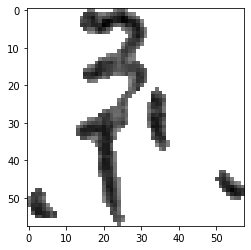

Prediction: 请. Truth: 请


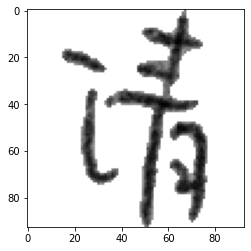

Prediction: 样. Truth: 样


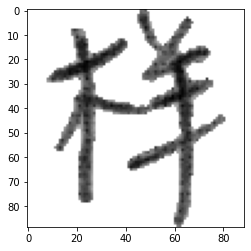

Prediction: 关. Truth: 关


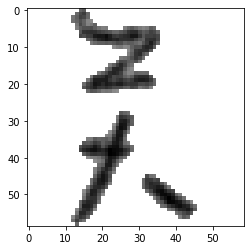

Prediction: 能. Truth: 能


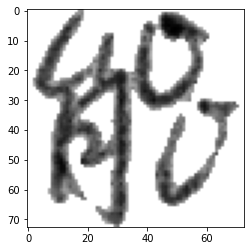

Prediction: 京. Truth: 京


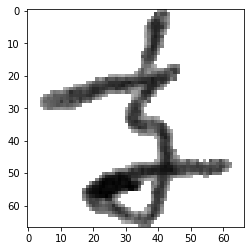

Prediction: 很. Truth: 很


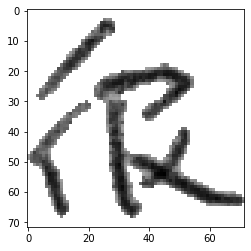

Prediction: 冷. Truth: 这


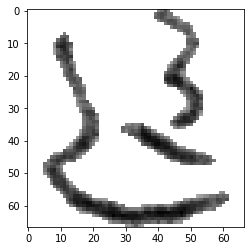

Prediction: 回. Truth: 国


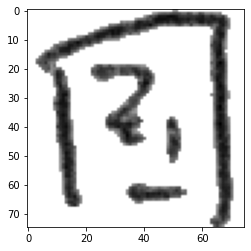

Prediction: 了. Truth: 多


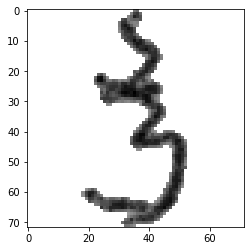

In [26]:
testing_model(model, image_transformer, folders, interpritation_dict)

**In conclusion, I can say that we have achieved our goals.**

We created and trained CRNN (CNN + LSTM cell) to recognize chineese characters and got great results!

**Thank you everyone who checked this notebook!**